In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable as V

import gym
import gym.spaces
import random
gym.logger.set_level(gym.logger.ERROR)
import numpy as np
from collections import namedtuple
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import time
import matplotlib.pyplot as plt
from matplotlib import animation
from builtins import super
from IPython.display import display, Image

In [2]:
def simulate_policy_gradient(update_fn, filename, init=[0.0]*3):
    a = widgets.FloatSlider(min=0.0, max=1.0, value=1.0, step=0.010)
    b = widgets.FloatSlider(min=0.0, max=1.0, value=1.0, step=0.005)
    c = widgets.FloatSlider(min=0.0, max=1.0, value=1.0, step=0.0025)
    sliders = [a, b, c]
    for i, s in zip(init, sliders):
        s.logit = i
        s.q_val = s.step * 1000
    
    def update_values():
        exps = [np.exp(e.logit) for e in sliders]
        for ex, slid in zip(exps, sliders):
            slid.value = ex / np.sum(exps)
            slid.grad = slid.value * (1-slid.value)
            
    update_values()
    
    def f(a_val10, b_val8, c_val7):
        pass
    
    np.random.seed(1)
    it = 0
    animation_data = []
    while all([v.value < 0.95 for v in [a, b, c]]):
        incr_idx, incr_size = update_fn(sliders)
        update_values()
        it += 1
        animation_data.append((incr_idx, incr_size, [v.value for v in sliders]))
        
    if filename is not None:
        fig, ax = plt.subplots()

        def plot_animation(i):
            plt.clf()
            incr_idx, incr_size, values = animation_data[i]
            plt.bar(['Val = %s' % (v.step * 1000) for v in sliders], values, width=0.5)
            plt.ylim(0, 1.19)
            if incr_size > 0:
                plt.annotate('',
                    xy=(incr_idx, values[incr_idx] + incr_size + 0.05), xycoords='data',
                    xytext=(incr_idx, values[incr_idx]), textcoords='data',
                    arrowprops=dict(width=5, connectionstyle="arc3", color='green'),
                )
            else:
                plt.annotate('',
                    xy=(incr_idx, values[incr_idx]), xycoords='data',
                    xytext=(incr_idx, values[incr_idx] - incr_size + 0.05), textcoords='data',
                    arrowprops=dict(width=5, connectionstyle="arc3", color='red'),
                )
            return fig,

        ani = animation.FuncAnimation(fig, plot_animation, frames=list(range(0, len(animation_data))), blit=False)
        ani.save(filename, writer='imagemagick', fps=10)
        plt.close()
        display(Image(filename))    
    
    print('Done in %s iterations' % it)

MovieWriter imagemagick unavailable; using Pillow instead.


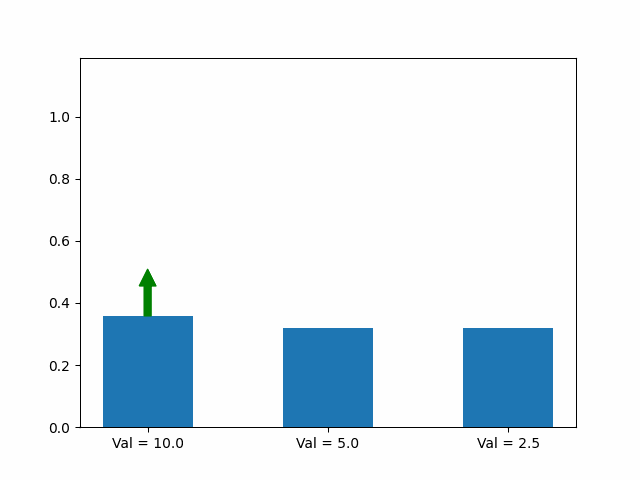

Done in 55 iterations


In [3]:
lr = 0.5

def update_known_optimal(actions):
    # Each action has a .logit attribute that we must update. It also has a .grad attribute
    # that gives the gradient of the that action.
    actions[0].logit += lr * actions[0].grad
    # We return the index of the action we updated and the size of the arrow to draw
    # (which should be the size of our update, divided by a scaling factor to make the 
    # visual more pleasant)
    return 0, lr / 5
    
simulate_policy_gradient(update_known_optimal, 'known_optimal.gif')

MovieWriter imagemagick unavailable; using Pillow instead.


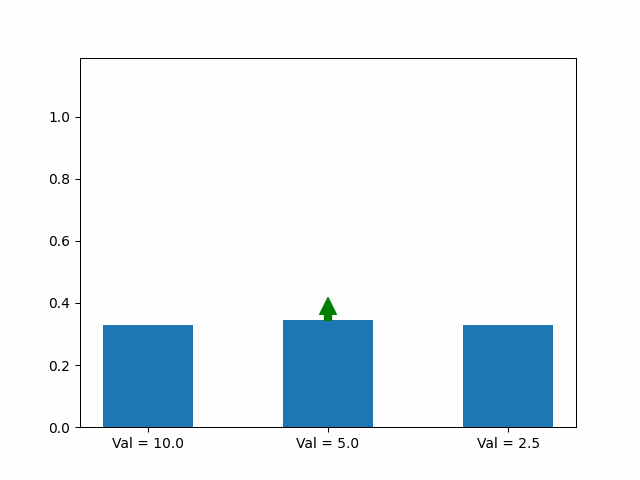

Done in 58 iterations


In [4]:
lr = 0.1

def update_q_value(actions):
    i = np.random.choice(list(range(len(actions))))
    # We add a significant amount of normally distributed noise to the action value,
    # which is given to us in the q_val attribute.
    value_est = actions[i].q_val + np.random.randn() * actions[i].q_val
    actions[i].logit += lr * value_est * actions[i].grad
    return i, lr * value_est / 10
    
simulate_policy_gradient(update_q_value, 'random_action.gif')

MovieWriter imagemagick unavailable; using Pillow instead.


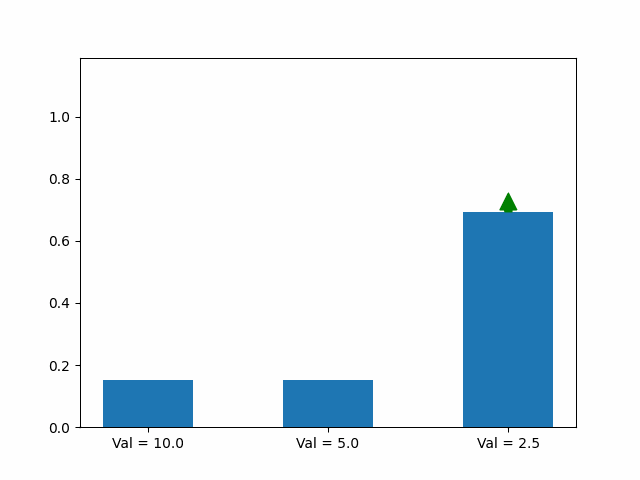

Done in 122 iterations


In [8]:
# Note: because using the advantage function partly compensates for this effect,
# we use the Q function here to make the effect more obvious.

lr = 0.1

def update_q_value_bad(actions):
    i = np.random.choice(list(range(len(actions))), p=[e.value for e in actions])
    q_value_est = actions[i].q_val + np.random.randn() * actions[i].q_val
    actions[i].logit += lr * q_value_est * actions[i].grad
    return i, lr * q_value_est / 5
    
simulate_policy_gradient(update_q_value_bad, 'bad.gif', init=[0.0, 0., 1.5])

MovieWriter imagemagick unavailable; using Pillow instead.


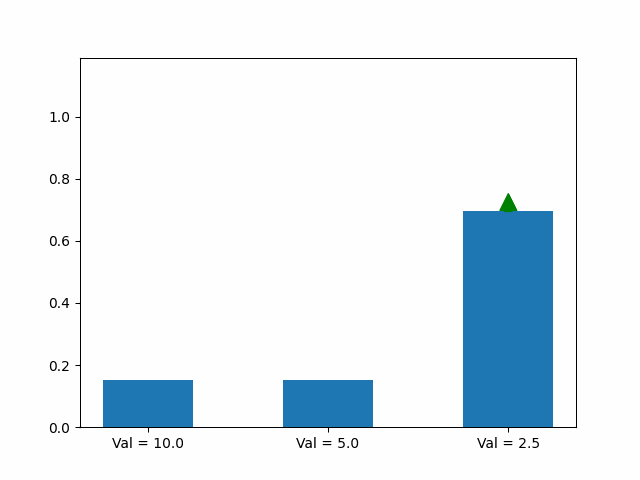

Done in 30 iterations


In [9]:
lr = 0.1

def update_q_value_fixed(actions):
    i = np.random.choice(list(range(len(actions))), p=[e.value for e in actions])
    q_value_est = actions[i].q_val + np.random.randn() * actions[i].q_val
    actions[i].logit += lr * q_value_est * actions[i].grad / actions[i].value
    return i, lr * q_value_est / actions[i].value / 10
    
simulate_policy_gradient(update_q_value_fixed, 'final_policy_grad.gif', init=[0., 0.0, 1.5])